In [17]:
#!/usr/bin/env python

import time, math, torch, re, argparse,re
import torch.nn as nn
import matplotlib.pyplot as plt
import networkx as nx
from src.scott import *
# parser = argparse.ArgumentParser()
# parser.add_argument('-d', "--device", default='cpu', help="device to use(GPU or CPU(defualt))")
# parser.add_argument('-e', "--num_epochs", default=10000, help="number of epochs")
# parser.add_argument('-hln', "--hidden_layer_size", default=4, help="number of nodes for the hidden layer", )
# parser.add_argument('-s', "--shuffle", default=False,
#                     help="shuffle the datatset to split into train set and validation set")
# parser.add_argument('-a', "--agumentation", default=False,
#                     help="increase the number of sample per dataset replicating the original sample")
# parser.add_argument('-lr', "--learning_rate", default=0.001, help="learning rate for the optimizer")
# parser.add_argument('-r', "--report", default=False, help="save result in a report file")
# parser.add_argument('-root', "--rootDir", default='', help="directory of file")
# parser.add_argument('-trf', "--trainFile", default=False, help="train")
# parser.add_argument('-tef', "--testFile", default=False, help="predict")
# parser.add_argument('-b', "--bias", default=1, help="bias value")
# args = parser.parse_args()
# num_epochs = int(args.num_epochs)
# hidden_layer = int(args.hidden_layer_size)
# shuffle = bool(args.shuffle)
# agumentation = bool(args.agumentation)
# save = bool(args.report)
# learning_rate = float(args.learning_rate)
# rootDir = (args.rootDir)
# trainFile = (args.trainFile)
# testFile = (args.testFile)
# bias = (args.bias)
# device = torch.device(args.device)
# print(args)

In [18]:
def parse(newick):
    tokens = re.findall(r"([^:;,()\s]*)(?:\s*:\s*([\d.]+)\s*)?([,);])|(\S)", newick + ";")
    def recurse(nextid=0, parentid=-1):  # one node
        thisid = nextid;
        children = []
        name, length, delim, ch = tokens.pop(0)
        if ch == "(":
            while ch in "(,":
                node, ch, nextid = recurse(nextid + 1, thisid)
                children.append(node)
            name, length, delim, ch = tokens.pop(0)
        return {"id": thisid, "name": name, "length": float(length) if length else None,
                "parentid": parentid, "children": children}, delim, nextid

    return recurse()[0]


def molecule_to_networkxGraph(filename):
    compounds = st.parse.from_sdf(
        file_path=filename, ignore_hydrogens=True)[0]
    simple_cgraph = str(st.canonize.to_cgraph(compounds))
    gr = [parse(simple_cgraph)]
    mol = nx.DiGraph()
    nodeDict = {}
    for g in gr:
        nodeDict[g["id"]] = g["name"]
        mol.add_node(g["id"])
        mol.nodes[g["id"]]["atom"] = g["name"]
        if len(g["children"]) > 0:
            for child in g["children"]:
                if child["name"]!= "":
                    nodeDict[child["id"]] = child["name"]
                    mol.add_edge(child["id"], child["parentid"], weight=child["length"])
                    mol.nodes[child["id"]]["atom"] = child["name"]
                    gr.append(child)
    
    return mol


In [19]:
def load_true_value(base, filenamepath):
    Y = {}
    datasetname = []
    filenamepath = base + filenamepath
    filehandle = open(filenamepath, 'r')
    while True:
        # read a single line
        line = filehandle.readline()
        if not line:
            break
        value = line.split(' ')
        Y[value[0]] = torch.FloatTensor([float(value[1])])
        datasetname.append(base + value[0])
    # close the pointer to that file
    filehandle.close()
    return datasetname, Y

In [20]:
# rootDir = './PAH/'
# i=0
# trainFile = "trainset_"+str(i)+".ds"
# testFile = "testset_"+str(i)+".ds"
# y=load_true_value(rootDir,testFile)
# print(y)

# rootDir = './Alkane/'
# i=0
# trainFile = "trainset_"+str(i)+".ds"
# testFile = "testset_"+str(i)+".ds"
# y=load_true_value(rootDir,testFile)
# print(y)



In [21]:
def dict_of_file_name_list(base, datasetname):
    GraphsDictList = {}
    # construct graphs from every single .ct file
    for filename in datasetname:
        GraphsDictList[filename.replace(base, '')] = molecule_to_networkxGraph(filename.replace(".ct",".sdf"))
    return GraphsDictList
def get_weight_sum(graph,node):
    bond=0
#     print("in",graph.in_edges(node,data=True))
#     print("in",graph.out_edges(node,data=True))
    for (u, v, d) in graph.in_edges(node,data=True):
        bond = bond + d["weight"]
        
    for (u, v, d) in graph.out_edges(node,data=True):
        bond = bond + d["weight"]
    return bond

# mol=molecule_to_networkxGraph("C:/Users/jiovy/Documents/GitHub/scott/data/molecule/cafeine.sdf")
# for node in mol:
#     print(get_weight_sum(mol,node))
# graphTrain, sorOrderedListTrain, depthNodesTrain, centerNodeTrain = dag_creator(
#         dict_of_file_name_list(rootDir, datasetFilenameTrain))

In [22]:
def dag_creator(GraphsDictList):
    finalGraphsDict = {}
    sorOrderedList = {}
    centers = {}
    depthNodes = {}
    atoms = {'C': [1, 0, 0, 0], 'S': [0, 1, 0, 0], 'O': [0, 0, 1, 0], 'N': [0, 0, 0, 1]}
    bondValue = {0: [0, 0, 0], 1: [0, 0, 1], 2: [0, 1, 0], 3: [0, 1, 1], 4: [1, 0, 0], 5: [1, 0, 1]}
    for g in GraphsDictList:
        for node in GraphsDictList[g]: 
            atom=GraphsDictList[g].nodes[node]["atom"]
            if atom in atoms:
                attrs = {node: { 'attrA1': float(atoms[atom][0]),'attrA2': float(atoms[atom][1]), 'attrA3': float(atoms[atom][2]), 'attrA4': float(atoms[atom][3])}}
            else :
                attrs = {node: { 'attrA1': 1,'attrA2': 1, 'attrA3': 1, 'attrA4': 1}}
            nx.set_node_attributes(GraphsDictList[g], attrs)
            bond=get_weight_sum(GraphsDictList[g],node)
            attrs = {node: {'attrB1': bondValue[bond][0], 'attrB2': bondValue[bond][1], 'attrB3': bondValue[bond][2]}}
            nx.set_node_attributes(GraphsDictList[g], attrs)
        finalGraphsDict[g], sorOrderedList[g], depthNodes[g], centers[g] = to_dag(GraphsDictList[g])
    return finalGraphsDict, sorOrderedList, depthNodes, centers

In [23]:
def to_dag(G, plot=False):
    '''  docstring:
    converte un grafo aciclico in un grafo dag 
    con i rami già diretti verso il centro.
    Input : grafo indiretto da covertire
    Output : grafo dag con grafico
    '''
    if (plot):
        nx.draw(G, with_labels=True, with_attributes=True)
        plt.show()
    centerDict = {}
#     src = nx.center(G)
#     for center in src:
    graphOrderedNodeTrav = {}
#         T = nx.dfs_tree(G, source=center)
#         G.remove_edges_from(list(G.edges()))
#         G = G.to_directed()
#         G.add_edges_from(list(T.edges()))
    center=[n for n,d in G.out_degree() if d==0][0] 
#     print(center)
    G = G.reverse()
    depthList = nx.shortest_path_length(G,center)
#     print(depthList)
    G = G.reverse()
    for n in nx.lexicographical_topological_sort(G):
        if (G.in_degree(n) > 0):
            sonListOrdered = []
            for p in sorted(list(G.predecessors(n)), key=lambda x: G.nodes[x]['atom']):
                G.nodes[n]['atom'] = G.nodes[n]['atom'] + G.nodes[p]['atom']
                sonListOrdered.append(p)
            graphOrderedNodeTrav[n] = sonListOrdered
        else:
            graphOrderedNodeTrav[n] = []
    centerDict[G.nodes[center]['atom']] = G, graphOrderedNodeTrav, depthList, center
    return centerDict[min(centerDict.keys())]

In [24]:
def get_d_value(Graph):
    labelSizeX = 7
    G = list(Graph.values())
    maxM = -1
    for g in G:
        for n in g.nodes():
            maxM = (max(maxM, g.in_degree(n)))
            # Size of the node array
        D = maxM + 1 + labelSizeX
    return D, maxM

In [25]:
def create_graph_tensor(Graphs, bias, maxM, DValue):
    graphTensor = {}
    for g in Graphs.keys():
        G = Graphs[g]
        nodes = {}
        for n in nx.lexicographical_topological_sort(G):
            x = torch.zeros(DValue, dtype=torch.float)
            x[0] = bias
            X = [G.nodes[n].pop('attrA1'), G.nodes[n].pop('attrA2'), G.nodes[n].pop('attrA3'), G.nodes[n].pop('attrA4'), G.nodes[n].pop('attrB1'),
                 G.nodes[n].pop('attrB2'), G.nodes[n].pop('attrB3')]
            if (len(X) > 0):
                i = maxM + 1
                for att in X:
                    x[i] = att
                    i = i + 1
            nodes[n] = x.view(DValue, 1)
        graphTensor[g] = nodes
    return graphTensor

In [26]:
def dataset_loader(depthNodes, centerNode, sorOrderedList, graphTensor, label, DValue, device):
    deepthdictBatchLabel = torch.zeros(0)
    deepthdictBatchTensor = {}
    deepthdictBatchParentListSons = {}
    dummyDict = {}

    for molecule in centerNode:
        deepthdictBatchLabel = torch.cat([deepthdictBatchLabel, label[molecule]])
        queue = []
        queue.append(centerNode[molecule])
        while (len(queue) > 0):
            current = queue.pop(0)
            depth = depthNodes[molecule][current]
            if depth in deepthdictBatchTensor.keys():
                deepthdictBatchTensor[depth] = torch.cat([deepthdictBatchTensor[depth], graphTensor[molecule][current]],
                                                         dim=0)
                deepthdictBatchParentListSons[depth].append(len(sorOrderedList[molecule][current]))
            else:
                deepthdictBatchTensor[depth] = graphTensor[molecule][current]
                deepthdictBatchParentListSons[depth] = [len(sorOrderedList[molecule][current])]
            queue.extend(sorOrderedList[molecule][current])
    dummyDict = {}
    for depth in reversed(range(1, len(
            deepthdictBatchParentListSons))):  # non considero il primo livello in quanto sicuramente non ha figli
        nodeOfNextLevel = len(deepthdictBatchParentListSons[depth - 1])
        nodeOfLevel = len(deepthdictBatchParentListSons[depth])
        dummy = torch.zeros(DValue * nodeOfNextLevel, nodeOfLevel)
        oriz = 0
        vert = 1
        for node in deepthdictBatchParentListSons[depth - 1]:
            vertTemp = vert
            for son in range(node):
                dummy[vertTemp][oriz] = 1
                oriz += 1
            vertTemp = +1
            vert += DValue
        dummyDict[depth - 1] = dummy.to_sparse().to(device)

    for depth in deepthdictBatchTensor:
        deepthdictBatchTensor[depth] = deepthdictBatchTensor[depth].to(device)

    deepthdictBatchLabel = deepthdictBatchLabel.view(-1, 1).to(device)
    return dummyDict, deepthdictBatchTensor, deepthdictBatchLabel

In [27]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()  # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size,
                             bias=False)  # 1st Full-Connected Layer:  (input data) ->  (hidden node)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, output_size,
                             bias=False)  # 2nd Full-Connected Layer:  (hidden node) ->  (output class)
        nn.init.kaiming_normal_(self.fc2.weight)
#         self.LRelu = nn.LeakyReLU(0.25)
        self.LRelu = nn.SELU()
        self.fc1Root = nn.Linear(input_size, hidden_size,
                                 bias=False)  # 1st Full-Connected Layer:  (input data) ->  (hidden node)
        nn.init.kaiming_normal_(self.fc1Root.weight)
        self.fc2Root = nn.Linear(hidden_size, output_size,
                                 bias=False)  # 2nd Full-Connected Layer:  (hidden node) ->  (output class)
        nn.init.kaiming_normal_(self.fc2Root.weight)
#         self.LReluRoot = nn.LeakyReLU(0.25)
        self.LReluRoot = nn.SELU()

    def forward(self, batchTensor, deep):
        if deep == 0:
            out = self.fc1Root(batchTensor)
            out = self.LReluRoot(out)
            out = self.fc2Root(out)
            return out
        else:
            out = self.fc1(batchTensor)
            out = self.LRelu(out)
            out = self.fc2(out)
            return out

In [28]:
def train(net, dataSetTrain, dataSetTest, optimizer, num_epochs, DValue):
    criterionMean = nn.MSELoss()
    # # Training loop
    RMSETrain = []
    RMSETest = []
    start = time.time()
    losses = 0
    dummyDict, deepthdictBatchTensor, deepthdictBatchLabel = dataSetTrain
    for epoch in range(num_epochs):
        leafIndex = len(deepthdictBatchTensor) - 1
        res = net(deepthdictBatchTensor[leafIndex].view(-1, DValue), leafIndex)
        for depth in reversed(range(0, len(deepthdictBatchTensor) - 1)):
            res = net(torch.sparse.addmm(deepthdictBatchTensor[depth], dummyDict[depth], res).view(-1, DValue), depth)
        losses = criterionMean(res, deepthdictBatchLabel)
        optimizer.zero_grad()
        losses = losses + (net.fc1.weight.norm() + net.fc2.weight.norm()) + 0.20 * (
                net.fc1Root.weight.norm() + net.fc2Root.weight.norm())
        losses.backward()
        optimizer.step()
        if (epoch + 1) % (int(num_epochs / 10)) == 0:  # print every (num_epochs/10) epochs --> total 10 print
            print('TRAIN SET \nEpoch [%d/%d],  \nRMSE: %.5f \n '
                  % (epoch + 1, num_epochs, math.sqrt(losses)))
            RMSETest.append(predict(net, dataSetTest, DValue, rmse=True))
            RMSETrain.append(math.sqrt(losses))

#             print('-------------------------------------------------------------------------------------\n\n')

    end = time.time()
    training_time = end - start
    print('Tempo di training ', training_time)
    print('FINE TRAINING')
    print('\n+++++++++++++++++++++++++++++++++++++++\n\n')
    print('RMSETest', RMSETest)
    print('RMSETrain', RMSETrain)
    return RMSETrain, RMSETest, training_time

In [29]:
def predict(net, dataSetTrain, DValue, rmse=False):
    avg_error = 0
    with torch.no_grad():
        lossesMean = 0
        criterionMean = nn.MSELoss()
        result = 0
        dummyDict, deepthdictBatchTensor, deepthdictBatchLabel = dataSetTrain
        leafIndex = len(deepthdictBatchTensor) - 1
        result = net(deepthdictBatchTensor[leafIndex].view(-1, DValue), leafIndex)
        for depth in reversed(range(0, len(deepthdictBatchTensor) - 1)):
            result = net(torch.addmm(deepthdictBatchTensor[depth], dummyDict[depth], result).view(-1, DValue), depth)
        lossesMean = criterionMean(result, deepthdictBatchLabel)
    for t in (result.sub(deepthdictBatchLabel)).tolist():
        avg_error += abs(t[0])
    avg_error = avg_error / len(deepthdictBatchLabel)
    print('VALIDATION SET ')
    print('RMSE: ', math.sqrt(lossesMean))
    print('Average Error: ', avg_error)
    if (rmse):
        return math.sqrt(lossesMean)
    else:
        for i in range(len(deepthdictBatchLabel)):
            deepthdictBatchLabel[i] = deepthdictBatchLabel[i].item()
        return result.view(-1).tolist(), deepthdictBatchLabel.cpu(), avg_error

In [30]:
def plot_rmse(true, predicted, RMSETrain, RMSETest):
    # plotting points as a scatter plot 0
    plt.scatter(true, predicted, label="C", color="green", marker="*", s=30)

    # x-axis label
    plt.xlabel('Real')
    # frequency label
    plt.ylabel('Predicted')
    # plot title  third_tensor = torch.cat((first_tensor, second_tensor), 0)
    plt.title('Regression of Alkan')
    # showing legend
    plt.legend()
    plt.grid()
    plt.savefig('./REPORT/' + testFile + "PredReal.png")
    # function to show the plot retain_graph=True
    plt.show()
    plt.close()  # close the figure window
    # plotting points as a scatter pltorch.autograd.backwardot
    plt.plot(RMSETrain, color="blue", label='RMSETrain')
    plt.plot(RMSETest, color="red", label='RMSETest')
    plt.legend()
    plt.grid()
    plt.title('RMSE of Alkan')
    plt.savefig('./REPORT/' + testFile + "RMSE.png")
    plt.show()


def report_stamp(fileName, fileNameRMSE, avg_error, RMSETrain, RMSETest, num_epochs, true, predicted, optimizer,
                graphSetTrain, graphSetTest, net, criterion, training_time):
    file = open(fileName, 'w+')
    file.write(
        '\n+++++++++++++++++++++++++++++++++++REPORT+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    file.write('\nLISTA TEST FILE  \n')
    file.write(str(graphSetTrain.keys()))
    file.write(
        '----------------------------------------------------------------------------------------------------------\n')
    file.write('\nLISTA VALIDATION FILE  \n')
    file.write(str(graphSetTest.keys()))
    file.write(
        '----------------------------------------------------------------------------------------------------------\n')
    file.write("\nOur model: \n\n")
    file.write(str(net))
    file.write('\n')
    file.write("Printing children\n------------------------------")
    file.write(str(list(net.children())))
    file.write("\n\nPrinting Modules\n------------------------------")
    file.write(str(list(net.modules())))
    file.write("\nThe state dict keys: \n\n")
    file.write(str(net.state_dict().keys()))
    file.write('Models state_dict:')
    for param_tensor in net.state_dict():
        file.write(param_tensor)
        file.write("\t")
        file.write(str(net.state_dict()[param_tensor].size()))
    file.write(str(net.state_dict()))
    file.write(
        '\n---------------plt.close(fig)    # close the figure window-------------------------------------------------------------------------------------------\n')
    file.write("\n Optimizer's state_dict:")
    file.write('\n')
    file.write("CRITERION = ")
    file.write(str(criterion))
    file.write('\n')
    file.write("OPTIMIZER = ")
    file.write(str(optimizer))
    file.write('\n')
    file.write('Tempo di training ')
    file.write(str(training_time))
    file.write('\n\n\n')
    for var_name in optimizer.state_dict():
        file.write(var_name)
        file.write("\t")
        file.write(str(optimizer.state_dict()[var_name]))
    file.write(
        '\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    file.write('Average Error Test Dataset= ')
    file.write(str(avg_error))
    file.write('\nRMSE Train Dataset = ')
    file.write(str(RMSETrain))
    file.write('\nRMSE Test Dataset = ')
    file.write(str(RMSETest))
    file.write('\nNumber of epochs ')
    file.write(str(num_epochs))
    file.write(
        '\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    for i in range(len(true)):  # close the figure window
        file.write('pred =')
        file.write(str(predicted[i]))
        file.write('\n')
        file.write('true = ')
        file.write(str(true[i]))
        file.write('\n')
        file.write('differenza = ')
        file.write(str(abs(predicted[i] - true[i])))
        file.write('\n\n\n')
    file.close()
    rmse_stamp(fileNameRMSE, avg_error, RMSETrain[-1], RMSETest[-1], num_epochs, optimizer, criterion, training_time)


def rmse_stamp(fileNameRMSE, avg_error, RMSETrain, RMSETest, num_epochs, optimizer, criterion, training_time):
    file = open(fileNameRMSE, 'w+')
    file.write(
        '\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    file.write('Average Error Test Dataset= ')
    file.write(str(avg_error))
    file.write('\nRMSE Train Dataset = ')
    file.write(str(RMSETrain))
    file.write('\nRMSE Test Dataset = ')
    file.write(str(RMSETest))
    file.write('\nNumber of epochs ')
    file.write(str(num_epochs))
    file.write(
        '\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    file.write("CRITERION = ")
    file.write(str(criterion))
    file.write('\n')
    file.write("OPTIMIZER = ")
    file.write(str(optimizer))
    file.write('\n')
    file.write('Tempo di training ')
    file.write(str(training_time))
    file.write(
        '\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n\n')
    file.close()

TRAIN SET 
Epoch [900/9000],  
RMSE: 29.56138 
 
VALIDATION SET 
RMSE:  36.53657267147707
Average Error:  29.568315807141754
TRAIN SET 
Epoch [1800/9000],  
RMSE: 20.03840 
 
VALIDATION SET 
RMSE:  26.056043817770835
Average Error:  20.090700852243526
TRAIN SET 
Epoch [2700/9000],  
RMSE: 13.19840 
 
VALIDATION SET 
RMSE:  17.211208789850076
Average Error:  12.322375648900083
TRAIN SET 
Epoch [3600/9000],  
RMSE: 11.45440 
 
VALIDATION SET 
RMSE:  14.246320282850673
Average Error:  9.948392968428763
TRAIN SET 
Epoch [4500/9000],  
RMSE: 10.19926 
 
VALIDATION SET 
RMSE:  12.759284136072802
Average Error:  9.52482042814556
TRAIN SET 
Epoch [5400/9000],  
RMSE: 8.97446 
 
VALIDATION SET 
RMSE:  11.730847921985434
Average Error:  9.197161222759046
TRAIN SET 
Epoch [6300/9000],  
RMSE: 8.22498 
 
VALIDATION SET 
RMSE:  11.019208955429512
Average Error:  8.777100111308851
TRAIN SET 
Epoch [7200/9000],  
RMSE: 7.74112 
 
VALIDATION SET 
RMSE:  10.179927703061097
Average Error:  8.08155180278

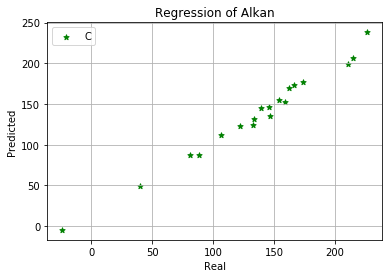

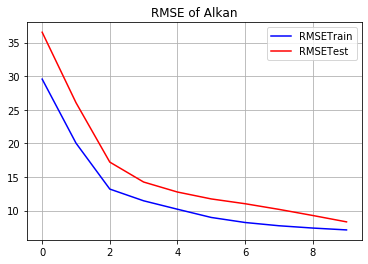

TRAIN SET 
Epoch [900/9000],  
RMSE: 24.55182 
 
VALIDATION SET 
RMSE:  23.941451819686606
Average Error:  19.914689716539886
TRAIN SET 
Epoch [1800/9000],  
RMSE: 15.03433 
 
VALIDATION SET 
RMSE:  13.696495131304065
Average Error:  10.954714122571444
TRAIN SET 
Epoch [2700/9000],  
RMSE: 11.95833 
 
VALIDATION SET 
RMSE:  10.906012152671513
Average Error:  8.348977339895148
TRAIN SET 
Epoch [3600/9000],  
RMSE: 10.15753 
 
VALIDATION SET 
RMSE:  9.354127154588971
Average Error:  7.118070903577302
TRAIN SET 
Epoch [4500/9000],  
RMSE: 7.90756 
 
VALIDATION SET 
RMSE:  7.007839717408126
Average Error:  5.159107208251953
TRAIN SET 
Epoch [5400/9000],  
RMSE: 6.90009 
 
VALIDATION SET 
RMSE:  6.393381284521327
Average Error:  4.691418396799188
TRAIN SET 
Epoch [6300/9000],  
RMSE: 6.45479 
 
VALIDATION SET 
RMSE:  6.264092997711989
Average Error:  4.758030540064762
TRAIN SET 
Epoch [7200/9000],  
RMSE: 6.26993 
 
VALIDATION SET 
RMSE:  6.33357482583595
Average Error:  4.999330922176964
T

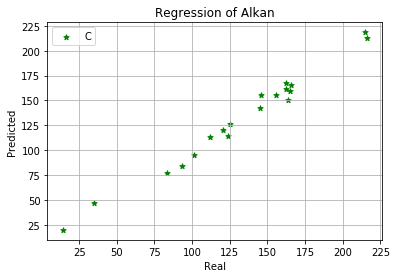

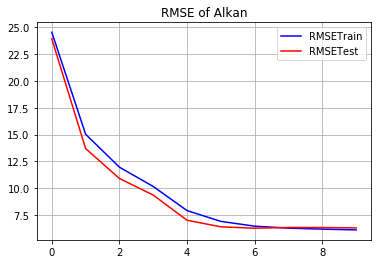

TRAIN SET 
Epoch [900/9000],  
RMSE: 24.67089 
 
VALIDATION SET 
RMSE:  31.035237619858716
Average Error:  24.842829854864824
TRAIN SET 
Epoch [1800/9000],  
RMSE: 16.87728 
 
VALIDATION SET 
RMSE:  21.7806103912097
Average Error:  18.449346040424548
TRAIN SET 
Epoch [2700/9000],  
RMSE: 12.30181 
 
VALIDATION SET 
RMSE:  14.297050033081563
Average Error:  11.725690339740954
TRAIN SET 
Epoch [3600/9000],  
RMSE: 10.05083 
 
VALIDATION SET 
RMSE:  11.167150306666409
Average Error:  8.798208136307565
TRAIN SET 
Epoch [4500/9000],  
RMSE: 7.95108 
 
VALIDATION SET 
RMSE:  8.298082741516778
Average Error:  6.809268951416016
TRAIN SET 
Epoch [5400/9000],  
RMSE: 7.06203 
 
VALIDATION SET 
RMSE:  6.762375119337781
Average Error:  5.816540768271999
TRAIN SET 
Epoch [6300/9000],  
RMSE: 6.62037 
 
VALIDATION SET 
RMSE:  5.972073094282841
Average Error:  5.122017910605983
TRAIN SET 
Epoch [7200/9000],  
RMSE: 6.45083 
 
VALIDATION SET 
RMSE:  5.569738928328358
Average Error:  4.622691104286595


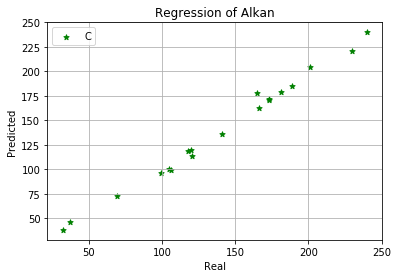

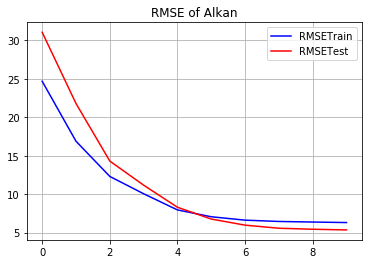

TRAIN SET 
Epoch [900/9000],  
RMSE: 29.25349 
 
VALIDATION SET 
RMSE:  34.056756611551215
Average Error:  27.825386895073784
TRAIN SET 
Epoch [1800/9000],  
RMSE: 23.43557 
 
VALIDATION SET 
RMSE:  28.883180194440694
Average Error:  22.80925072564019
TRAIN SET 
Epoch [2700/9000],  
RMSE: 13.03138 
 
VALIDATION SET 
RMSE:  19.689742090832873
Average Error:  12.332104153103298
TRAIN SET 
Epoch [3600/9000],  
RMSE: 11.45505 
 
VALIDATION SET 
RMSE:  17.20761252210595
Average Error:  11.34580527411567
TRAIN SET 
Epoch [4500/9000],  
RMSE: 8.92555 
 
VALIDATION SET 
RMSE:  12.402712838996216
Average Error:  8.888531155056423
TRAIN SET 
Epoch [5400/9000],  
RMSE: 7.08601 
 
VALIDATION SET 
RMSE:  7.937564158743532
Average Error:  5.983358595106337
TRAIN SET 
Epoch [6300/9000],  
RMSE: 6.48862 
 
VALIDATION SET 
RMSE:  6.731488877275429
Average Error:  5.420812818739149
TRAIN SET 
Epoch [7200/9000],  
RMSE: 6.35258 
 
VALIDATION SET 
RMSE:  6.543327881934988
Average Error:  5.377105289035374

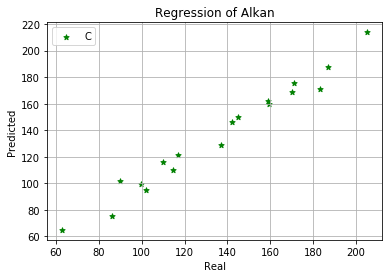

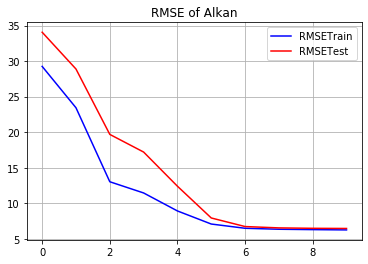

TRAIN SET 
Epoch [900/9000],  
RMSE: 28.67591 
 
VALIDATION SET 
RMSE:  23.901240283913616
Average Error:  20.274194717407227
TRAIN SET 
Epoch [1800/9000],  
RMSE: 22.51223 
 
VALIDATION SET 
RMSE:  19.34617074538953
Average Error:  16.078017552693684
TRAIN SET 
Epoch [2700/9000],  
RMSE: 14.07839 
 
VALIDATION SET 
RMSE:  14.576599891754485
Average Error:  11.448999192979601
TRAIN SET 
Epoch [3600/9000],  
RMSE: 11.82562 
 
VALIDATION SET 
RMSE:  13.731567790295912
Average Error:  11.175771077473959
TRAIN SET 
Epoch [4500/9000],  
RMSE: 9.68595 
 
VALIDATION SET 
RMSE:  11.329969542715778
Average Error:  9.297826555040148
TRAIN SET 
Epoch [5400/9000],  
RMSE: 7.40923 
 
VALIDATION SET 
RMSE:  8.691311885021435
Average Error:  6.733290301428901
TRAIN SET 
Epoch [6300/9000],  
RMSE: 6.60117 
 
VALIDATION SET 
RMSE:  7.3169529064498615
Average Error:  5.267645253075494
TRAIN SET 
Epoch [7200/9000],  
RMSE: 6.38739 
 
VALIDATION SET 
RMSE:  6.722497365205531
Average Error:  4.781033992767

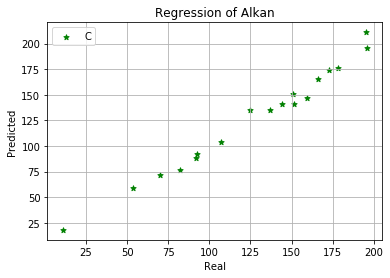

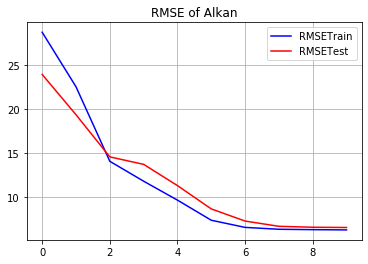

TRAIN SET 
Epoch [900/9000],  
RMSE: 30.87870 
 
VALIDATION SET 
RMSE:  25.42523602551459
Average Error:  23.926258087158203
TRAIN SET 
Epoch [1800/9000],  
RMSE: 28.35084 
 
VALIDATION SET 
RMSE:  23.815157844617836
Average Error:  22.50871319240994
TRAIN SET 
Epoch [2700/9000],  
RMSE: 24.58388 
 
VALIDATION SET 
RMSE:  21.614499403702514
Average Error:  20.328145768907333
TRAIN SET 
Epoch [3600/9000],  
RMSE: 12.19260 
 
VALIDATION SET 
RMSE:  9.752961711500568
Average Error:  7.747751871744792
TRAIN SET 
Epoch [4500/9000],  
RMSE: 8.49085 
 
VALIDATION SET 
RMSE:  7.042141629364418
Average Error:  5.0662384033203125
TRAIN SET 
Epoch [5400/9000],  
RMSE: 7.11925 
 
VALIDATION SET 
RMSE:  5.056200228565199
Average Error:  3.5515643225775824
TRAIN SET 
Epoch [6300/9000],  
RMSE: 6.68248 
 
VALIDATION SET 
RMSE:  3.9472157335030427
Average Error:  3.1036639743381076
TRAIN SET 
Epoch [7200/9000],  
RMSE: 6.58199 
 
VALIDATION SET 
RMSE:  3.525859397936701
Average Error:  2.9599022335476

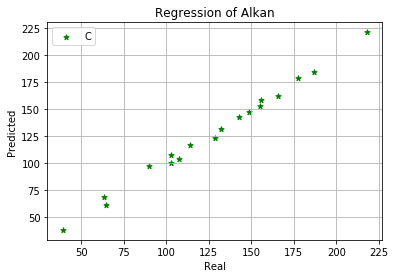

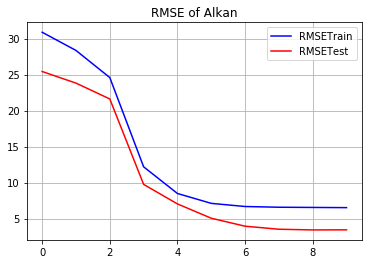

TRAIN SET 
Epoch [900/9000],  
RMSE: 29.30100 
 
VALIDATION SET 
RMSE:  24.61635937594715
Average Error:  21.959548950195312
TRAIN SET 
Epoch [1800/9000],  
RMSE: 21.22534 
 
VALIDATION SET 
RMSE:  16.362333334473952
Average Error:  14.187265396118164
TRAIN SET 
Epoch [2700/9000],  
RMSE: 13.43613 
 
VALIDATION SET 
RMSE:  9.446692833640991
Average Error:  7.963713539971246
TRAIN SET 
Epoch [3600/9000],  
RMSE: 12.22141 
 
VALIDATION SET 
RMSE:  8.994938592791279
Average Error:  7.56389405992296
TRAIN SET 
Epoch [4500/9000],  
RMSE: 11.06963 
 
VALIDATION SET 
RMSE:  8.12225718052211
Average Error:  6.5096791585286455
TRAIN SET 
Epoch [5400/9000],  
RMSE: 9.69372 
 
VALIDATION SET 
RMSE:  6.966821241108918
Average Error:  5.2415648566351996
TRAIN SET 
Epoch [6300/9000],  
RMSE: 6.92656 
 
VALIDATION SET 
RMSE:  4.783958316251392
Average Error:  3.7691819932725696
TRAIN SET 
Epoch [7200/9000],  
RMSE: 6.16799 
 
VALIDATION SET 
RMSE:  4.578075629999905
Average Error:  3.496128718058268


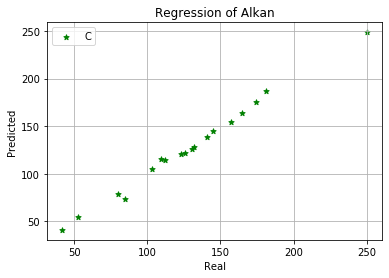

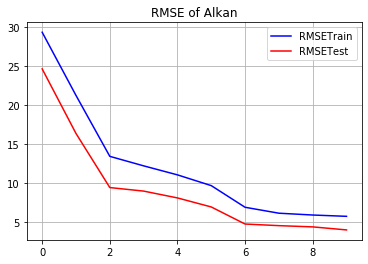

TRAIN SET 
Epoch [900/9000],  
RMSE: 28.54511 
 
VALIDATION SET 
RMSE:  27.87375956285712
Average Error:  25.051913367377388
TRAIN SET 
Epoch [1800/9000],  
RMSE: 22.50562 
 
VALIDATION SET 
RMSE:  19.331410454899075
Average Error:  17.12859323289659
TRAIN SET 
Epoch [2700/9000],  
RMSE: 14.86572 
 
VALIDATION SET 
RMSE:  7.221826731620798
Average Error:  5.9467447068956165
TRAIN SET 
Epoch [3600/9000],  
RMSE: 12.34184 
 
VALIDATION SET 
RMSE:  6.648310121062368
Average Error:  5.462403403388129
TRAIN SET 
Epoch [4500/9000],  
RMSE: 10.05855 
 
VALIDATION SET 
RMSE:  7.056998211341902
Average Error:  5.582241482204861
TRAIN SET 
Epoch [5400/9000],  
RMSE: 7.87816 
 
VALIDATION SET 
RMSE:  7.242722640692518
Average Error:  5.177710639105903
TRAIN SET 
Epoch [6300/9000],  
RMSE: 6.80236 
 
VALIDATION SET 
RMSE:  7.260894745055825
Average Error:  4.510453542073567
TRAIN SET 
Epoch [7200/9000],  
RMSE: 6.42177 
 
VALIDATION SET 
RMSE:  7.616329078232485
Average Error:  4.602585262722439
T

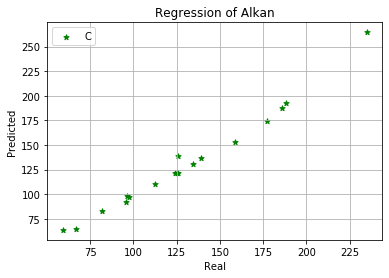

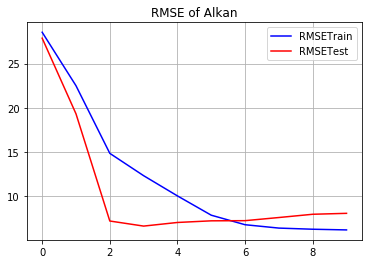

TRAIN SET 
Epoch [900/9000],  
RMSE: 30.42408 
 
VALIDATION SET 
RMSE:  28.128997111799507
Average Error:  23.24512227376302
TRAIN SET 
Epoch [1800/9000],  
RMSE: 25.14288 
 
VALIDATION SET 
RMSE:  22.08276473938796
Average Error:  17.950416988796658
TRAIN SET 
Epoch [2700/9000],  
RMSE: 18.16606 
 
VALIDATION SET 
RMSE:  15.857586779572726
Average Error:  12.316922081841362
TRAIN SET 
Epoch [3600/9000],  
RMSE: 13.13207 
 
VALIDATION SET 
RMSE:  10.672039427265501
Average Error:  8.84885999891493
TRAIN SET 
Epoch [4500/9000],  
RMSE: 10.94413 
 
VALIDATION SET 
RMSE:  8.595356739001769
Average Error:  7.073727501763238
TRAIN SET 
Epoch [5400/9000],  
RMSE: 7.64324 
 
VALIDATION SET 
RMSE:  6.718194415164775
Average Error:  5.49503050910102
TRAIN SET 
Epoch [6300/9000],  
RMSE: 6.75773 
 
VALIDATION SET 
RMSE:  5.796751612252365
Average Error:  4.591875076293945
TRAIN SET 
Epoch [7200/9000],  
RMSE: 6.51037 
 
VALIDATION SET 
RMSE:  5.405614209137324
Average Error:  4.218694898817274
T

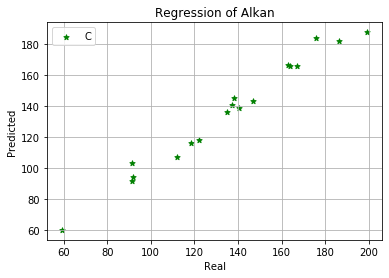

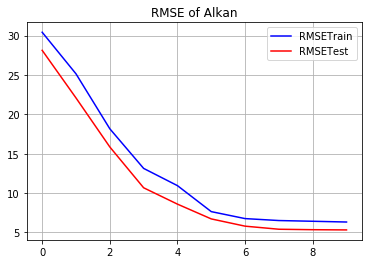

TRAIN SET 
Epoch [900/9000],  
RMSE: 56.93447 
 
VALIDATION SET 
RMSE:  61.15615019792572
Average Error:  49.00379350450304
TRAIN SET 
Epoch [1800/9000],  
RMSE: 54.34462 
 
VALIDATION SET 
RMSE:  59.885201049069714
Average Error:  47.41656027899848
TRAIN SET 
Epoch [2700/9000],  
RMSE: 53.09730 
 
VALIDATION SET 
RMSE:  57.56621315046157
Average Error:  45.33891847398546
TRAIN SET 
Epoch [3600/9000],  
RMSE: 40.58975 
 
VALIDATION SET 
RMSE:  45.32544804229049
Average Error:  37.162488513522675
TRAIN SET 
Epoch [4500/9000],  
RMSE: 16.96254 
 
VALIDATION SET 
RMSE:  14.69227554926158
Average Error:  11.28017086452908
TRAIN SET 
Epoch [5400/9000],  
RMSE: 9.97540 
 
VALIDATION SET 
RMSE:  7.327558873804581
Average Error:  5.54201062520345
TRAIN SET 
Epoch [6300/9000],  
RMSE: 7.75442 
 
VALIDATION SET 
RMSE:  6.785257728533748
Average Error:  5.600166108873156
TRAIN SET 
Epoch [7200/9000],  
RMSE: 6.66209 
 
VALIDATION SET 
RMSE:  6.800076977911175
Average Error:  5.314740286933051
TRA

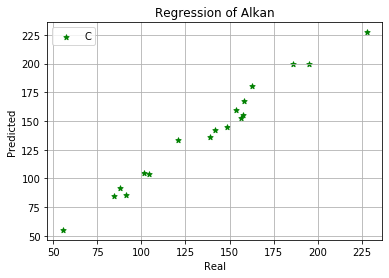

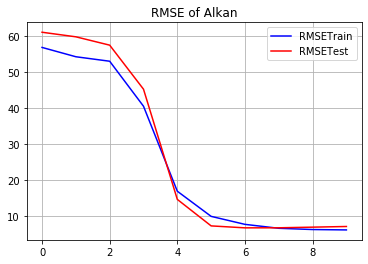

In [33]:
for i in range(10):

    num_epochs = 10000
    bias=1
    rootDir = './Acyclic/'
    trainFile = "trainset_"+str(i)+".ds"
    testFile = "testset_"+str(i)+".ds"
    device = torch.device("cpu")


    datasetFilenameTrain, labelTrain = load_true_value(rootDir, trainFile)
    graphTrain, sorOrderedListTrain, depthNodesTrain, centerNodeTrain = dag_creator(
        dict_of_file_name_list(rootDir, datasetFilenameTrain))
    DTrain, maxMTrain = get_d_value(graphTrain)

    datasetFilenameTest, labelTest = load_true_value(rootDir, testFile)
    graphTest, sorOrderedListTest, depthNodesTest, centerNodeTest = dag_creator(dict_of_file_name_list(rootDir, datasetFilenameTest))
    DTest, maxMTest = get_d_value(graphTest)

    DValue = max(DTrain, DTest)
    maxMValue = max(maxMTrain, maxMTest)

    graphTensorTrain = create_graph_tensor(graphTrain, bias, maxMValue, DValue)
    dataSetTrain = dataset_loader(depthNodesTrain, centerNodeTrain, sorOrderedListTrain, graphTensorTrain, labelTrain,
                                 DValue, device)

    graphTensorTest = create_graph_tensor(graphTest, bias, maxMValue, DValue)
    dataSetTest = dataset_loader(depthNodesTest, centerNodeTest, sorOrderedListTest, graphTensorTest, labelTest, DValue,
                                device)

    input_size = DValue  # The image size = 28 x 28 = 784
    hidden_size = 4  # The number of nodes at the hidden layer
    output_size = 1  # The number of output classes. In this case, from 0 to 9

    net = Net(input_size, hidden_size, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters())
    # optimizer = torch.optim.RMSprop(net.parameters())


    RMSETrain, RMSETest, training_time = train(net, dataSetTrain, dataSetTest, optimizer, num_epochs, DValue)
    predicted, true, avg_error = predict(net, dataSetTest, DValue)
    plot_rmse(true, predicted, RMSETrain, RMSETest)
    fileName = './REPORT/' + testFile + 'ReportGenerale.txt'
    fileNameRMSE = './REPORT/' + testFile + 'ReportRMSE.txt'
    report_stamp(fileName, fileNameRMSE, avg_error, RMSETrain, RMSETest, num_epochs, true, predicted, optimizer, graphTrain,
                graphTest, net, criterion, training_time)

